In [119]:
import datetime as dt
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump, load
from math import sqrt
from keras.layers import Dense, GRU, LSTM, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model
import os
import warnings
warnings.filterwarnings("ignore")

In [120]:
### Setting simulation year and learning period
SimulationYear = 2021
Period = 10
LearningYearStart = SimulationYear - Period + 1

In [121]:
### Stock symbol
code = "EURUSD"
### Prepared dataset with indicators
PreparedDatasetPath = "Datasets_with_Indicators/"+code+".csv"
### Dataset for backtesting simulation path
SimulationDatasetPath = "SimulationDatasets/Prediction/"+code+"_"+str(SimulationYear)+".csv"
### Creating directory for learning data
LearningDataPath = "PredictionData/"+code+"_"+str(SimulationYear)
if not os.path.exists(LearningDataPath):
   os.makedirs(LearningDataPath)

In [122]:
n_steps_in = 30
n_steps_out = 5

In [123]:
def get_simulation_data():
    org_dataset = pd.read_csv(PreparedDatasetPath, parse_dates=True)
    org_dataset.Date = pd.to_datetime(org_dataset.Date, dayfirst=True)
    org_dataset = org_dataset.set_index(org_dataset.Date)
    org_dataset = org_dataset.drop("ZigZag", axis="columns")

    org_dataset = org_dataset.drop("Return_rate", axis="columns")
    org_dataset = org_dataset.drop("RSI_7", axis="columns")
    org_dataset = org_dataset.drop("RSI_14", axis="columns")
    org_dataset = org_dataset.drop("MA_7", axis="columns")
    org_dataset = org_dataset.drop("MA_14", axis="columns")

    sim_dataset = org_dataset[str(SimulationYear)+"-01-02":str(SimulationYear)+"-12-31"]
    sim_dataset = sim_dataset.reset_index(drop=True)
    sim_dataset.to_csv(SimulationDatasetPath, index=False)

    return sim_dataset, len(sim_dataset)

## 1. Data Preprocessing

In [124]:
dataset = pd.read_csv(PreparedDatasetPath, parse_dates=True)
dataset.Date = pd.to_datetime(dataset.Date, dayfirst=True)
dataset = dataset.set_index(dataset.Date)
dataset = dataset.drop("Date", axis="columns")
dataset = dataset.drop("ZigZag", axis="columns")
dataset

,Open,High,Low,Close,Return_rate,RSI_7,RSI_14,MA_7,MA_14
Date,,,,,,,,,
2000-01-18,1.01110,1.01550,1.00720,1.01400,1.002769,36.106221,41.847381,1.019714,1.024307
2000-01-19,1.01410,1.01650,1.00850,1.01170,0.997732,32.411299,39.100201,1.016786,1.023271
2000-01-20,1.01160,1.01880,1.00730,1.01690,1.005140,46.777470,47.492823,1.014700,1.022393
2000-01-21,1.01660,1.01930,1.00500,1.00870,0.991936,33.627629,38.485863,1.012514,1.020707
2000-01-23,1.00280,1.00450,1.00260,1.00430,0.995638,28.595350,34.684738,1.011386,1.018836
...,...,...,...,...,...,...,...,...,...
2022-12-07,1.04670,1.05493,1.04427,1.05114,1.004223,64.103095,64.267401,1.050111,1.043287
2022-12-08,1.05115,1.05643,1.04892,1.05551,1.004157,69.392195,66.614241,1.052003,1.045037
2022-12-09,1.05549,1.05878,1.05032,1.05325,0.997859,63.726914,64.263552,1.052074,1.045859


In [125]:
dataset = dataset[str(LearningYearStart)+"-01-02":str(SimulationYear)+"-12-31"]
dataset

,Open,High,Low,Close,Return_rate,RSI_7,RSI_14,MA_7,MA_14
Date,,,,,,,,,
2012-01-02,1.29418,1.29681,1.29168,1.29517,1.000827,36.436361,35.847328,1.297531,1.301094
2012-01-03,1.29519,1.30762,1.29512,1.30476,1.007404,54.870125,44.511377,1.297374,1.301135
2012-01-04,1.30478,1.30719,1.28974,1.29326,0.991186,39.033340,37.901071,1.295419,1.300498
2012-01-05,1.29327,1.29434,1.27702,1.27911,0.989059,27.598652,31.669051,1.293856,1.298976
2012-01-06,1.27910,1.28121,1.26972,1.27188,0.994348,23.495626,29.041435,1.290561,1.296164
...,...,...,...,...,...,...,...,...,...
2021-12-27,1.13228,1.13336,1.13025,1.13292,1.000565,60.157393,52.099889,1.131183,1.129533
2021-12-28,1.13292,1.13329,1.12891,1.13125,0.998526,52.577906,49.445781,1.131696,1.129549
2021-12-29,1.13129,1.13681,1.12731,1.13593,1.004137,66.413362,56.182433,1.132731,1.130094


In [126]:
sim_dataset, TestLength= get_simulation_data()
sim_dataset

,Date,Open,High,Low,Close
0,2021-01-03,1.22382,1.22523,1.22269,1.22495
1,2021-01-04,1.22495,1.23091,1.22382,1.22522
2,2021-01-05,1.22521,1.23051,1.22468,1.22982
3,2021-01-06,1.22982,1.23488,1.22652,1.23377
4,2021-01-07,1.23378,1.23438,1.22445,1.22686
...,...,...,...,...,...
307,2021-12-27,1.13228,1.13336,1.13025,1.13292
308,2021-12-28,1.13292,1.13329,1.12891,1.13125
309,2021-12-29,1.13129,1.13681,1.12731,1.13593
310,2021-12-30,1.13593,1.13594,1.12979,1.13219


In [127]:
X_value = pd.DataFrame(dataset.iloc[:, :])
y_value = pd.DataFrame(dataset.Close)

In [128]:
X_value.head()

,Open,High,Low,Close,Return_rate,RSI_7,RSI_14,MA_7,MA_14
Date,,,,,,,,,
2012-01-02,1.29418,1.29681,1.29168,1.29517,1.000827,36.436361,35.847328,1.297531,1.301094
2012-01-03,1.29519,1.30762,1.29512,1.30476,1.007404,54.870125,44.511377,1.297374,1.301135
2012-01-04,1.30478,1.30719,1.28974,1.29326,0.991186,39.033340,37.901071,1.295419,1.300498
2012-01-05,1.29327,1.29434,1.27702,1.27911,0.989059,27.598652,31.669051,1.293856,1.298976
2012-01-06,1.27910,1.28121,1.26972,1.27188,0.994348,23.495626,29.041435,1.290561,1.296164


In [129]:
y_value.head()

,Close
Date,
2012-01-02,1.29517
2012-01-03,1.30476
2012-01-04,1.29326
2012-01-05,1.27911
2012-01-06,1.27188


In [130]:
# Normalized the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

dump(X_scaler, open(LearningDataPath+"/X_scaler.pkl", "wb"))
dump(y_scaler, open(LearningDataPath+"/y_scaler.pkl", "wb"))

In [131]:
n_features = X_value.shape[1]
print(n_features)

9


In [132]:
def get_X_y(X_data, y_data):
    X = list()
    y = list()

    length = len(X_data)
    for i in range(0, length-n_steps_in, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        if len(X_value) == n_steps_in and len(y_value) == n_steps_out:
            X.append(X_value)
            y.append(y_value)

    return np.array(X), np.array(y)

In [133]:
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in + n_steps_out - 1:, :].index

    return train_predict_index, test_predict_index

In [134]:
def split_train_test(data):
    train_size = len(X) - TestLength
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [135]:
X, y = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
train_predict_index, test_predict_index, = predict_index(dataset, X_train, n_steps_in, n_steps_out)
print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print("index_train shape:", train_predict_index.shape)
print("index_test shape:", test_predict_index.shape)

X shape:  (3078, 30, 9)
y shape:  (3078, 5)
X_train shape:  (2766, 30, 9)
y_train shape:  (2766, 5)
X_test shape:  (312, 30, 9)
y_test shape:  (312, 5)
index_train shape: (2770,)
index_test shape: (312,)


In [136]:
X_train.shape[0]

2766

In [137]:
train_predict_index

DatetimeIndex(['2012-02-06', '2012-02-07', '2012-02-08', '2012-02-09',
               '2012-02-10', '2012-02-12', '2012-02-13', '2012-02-14',
               '2012-02-15', '2012-02-16',
               ...
               '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=2770, freq=None)

In [138]:
test_predict_index

DatetimeIndex(['2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08', '2021-01-10', '2021-01-11',
               '2021-01-12', '2021-01-13',
               ...
               '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=312, freq=None)

In [139]:
np.save(LearningDataPath+"/X_train.npy", X_train)
np.save(LearningDataPath+"/y_train.npy", y_train)
np.save(LearningDataPath+"/X_test.npy", X_test)
np.save(LearningDataPath+"/y_test.npy", y_test)
np.save(LearningDataPath+"/train_predict_index.npy", train_predict_index)
np.save(LearningDataPath+"/test_predict_index.npy", test_predict_index)

## 2.1 GRU

In [ ]:
X_train = np.load(LearningDataPath+"/X_train.npy", allow_pickle=True)
y_train = np.load(LearningDataPath+"/y_train.npy", allow_pickle=True)
X_test = np.load(LearningDataPath+"/X_test.npy", allow_pickle=True)
y_test = np.load(LearningDataPath+"/y_test.npy", allow_pickle=True)

In [ ]:
LR = 0.0002
BATCH_SIZE = 64
N_EPOCH = 30

input_dim = X_train.shape[1]     # 30
feature_size = X_train.shape[2]  # 6
output_dim = y_train.shape[1]    # 5

In [ ]:
print(output_dim)

In [ ]:
def basic_GRU(input_dim, output_dim, feature_size):
    model = Sequential()
#     model.add(GRU(units=128, return_sequences = True, input_shape=(input_dim, feature_size)))
#     model.add(GRU(units=64, input_shape=(input_dim, feature_size)))
    model.add(GRU(units=256, input_shape=(input_dim, feature_size)))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))

    # model.compile(optimizer=Adam(lr=LR), loss="mse")
    model.compile(optimizer=Adam, loss="mse")
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    return model, history

In [ ]:
model, history = basic_GRU(input_dim, output_dim, feature_size)
print(model.summary())

In [ ]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Przebieg funkcji strat - GRU")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.xticks(np.arange(0, N_EPOCH, step=5))
plt.yticks(np.arange(0, history.history["loss"][0], step=0.01))
plt.legend()
plt.show()

In [ ]:
predicted_price = model.predict(X_test, verbose=0)

In [ ]:
rmse = sqrt(mean_squared_error(y_test, predicted_price))
print("Pierwiastek błędu średniokwadratowego (GRU): {:.4f}".format(rmse))

In [ ]:
score = int(rmse*10000)
model.save(LearningDataPath+"/PredictionModel.h5")
model.save(LearningDataPath+"/GRU_"+str(n_steps_in)+"_Days_"+str(score)+"rmse.h5")

## 2.2 GRU - Training

In [ ]:
model = load_model(LearningDataPath+"/GRU_"+str(n_steps_in)+"_Days_"+str(score)+"rmse.h5")

In [ ]:
train_predicted_price = model.predict(X_train, verbose=0)

In [ ]:
y_scaler = load(open(LearningDataPath+"/y_scaler.pkl", "rb"))
train_predict_index = np.load(LearningDataPath+"/train_predict_index.npy", allow_pickle=True)
rescaled_real_y = y_scaler.inverse_transform(y_train)
rescaled_predicted_y = y_scaler.inverse_transform(train_predicted_price)

In [ ]:
predicted_train_result_GRU = pd.DataFrame()
for i in range(rescaled_predicted_y.shape[0]):
    y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                             index=train_predict_index[i:i + output_dim])
    predicted_train_result_GRU = pd.concat([predicted_train_result_GRU, y_predict], axis=1, sort=False)

In [ ]:
real_train_price = pd.DataFrame()
for i in range(rescaled_real_y.shape[0]):
    y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                           index=train_predict_index[i:i + output_dim])
    real_train_price = pd.concat([real_train_price, y_train], axis=1, sort=False)

In [ ]:
predicted_train_result_GRU["predicted_mean"] = predicted_train_result_GRU.mean(axis=1)
real_train_price["real_mean"] = real_train_price.mean(axis=1)

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(real_train_price["real_mean"])
plt.plot(predicted_train_result_GRU["predicted_mean"], color="r")
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend(("Cena rzeczywista", "Cena przewidywana"), loc="upper left", fontsize=16)
plt.title("Zbiór treningowy - GRU", fontsize=20)
plt.show()

## 2.3 GRU - Testing

In [ ]:
model = load_model(LearningDataPath+"/GRU_"+str(n_steps_in)+"_Days_"+str(score)+"rmse.h5")

In [ ]:
test_predicted_price = model.predict(X_test, verbose=0)

In [ ]:
y_scaler = load(open(LearningDataPath+"/y_scaler.pkl", "rb"))
test_predict_index = np.load(LearningDataPath+"/test_predict_index.npy", allow_pickle=True)
rescaled_real_y = y_scaler.inverse_transform(y_test)
rescaled_predicted_y = y_scaler.inverse_transform(test_predicted_price)

In [ ]:
predicted_test_result_GRU = pd.DataFrame()
for i in range(rescaled_predicted_y.shape[0]):
    y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                             index=test_predict_index[i:i + output_dim])
    predicted_test_result_GRU = pd.concat([predicted_test_result_GRU, y_predict], axis=1, sort=False)

In [ ]:
real_test_price = pd.DataFrame()
for i in range(rescaled_real_y.shape[0]):
    y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                           index=test_predict_index[i:i + output_dim])
    real_test_price = pd.concat([real_test_price, y_train], axis=1, sort=False)

In [ ]:
predicted_test_result_GRU["predicted_mean"] = predicted_test_result_GRU.mean(axis=1)
real_test_price["real_mean"] = real_test_price.mean(axis=1)

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(real_test_price["real_mean"])
plt.plot(predicted_test_result_GRU["predicted_mean"], color="r")
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend(("Cena rzeczywista", "Cena przewidywana"), loc="upper left", fontsize=16)
plt.title("Zbiór testowy - GRU", fontsize=20)
plt.show()

## 3.1 LSTM

In [140]:
X_train = np.load(LearningDataPath+"/X_train.npy", allow_pickle=True)
y_train = np.load(LearningDataPath+"/y_train.npy", allow_pickle=True)
X_test = np.load(LearningDataPath+"/X_test.npy", allow_pickle=True)
y_test = np.load(LearningDataPath+"/y_test.npy", allow_pickle=True)

In [141]:
LR = 0.001
BATCH_SIZE = 32
N_EPOCH = 20

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [142]:
# def basic_lstm(input_dim, feature_size):
#     model = Sequential()
#     model.add(LSTM(units=256, input_shape=(input_dim, feature_size)))
#     model.add(Dense(64))
#     model.add(Dense(units=output_dim))
#     model.compile(optimizer=Adam(lr = LR), loss="mse")
#     history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
#                         verbose=2, shuffle=False)
#
#     return model, history

In [143]:
def basic_lstm(input_dim, input_feature_size):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(input_dim, input_feature_size)))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr = LR), loss="mse")
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    return model, history

In [144]:
model, history = basic_lstm(input_dim, feature_size)
print(model.summary())

Epoch 1/20
87/87 - 7s - loss: 0.0461 - val_loss: 0.0053 - 7s/epoch - 83ms/step
Epoch 2/20
87/87 - 1s - loss: 0.0205 - val_loss: 0.0027 - 1s/epoch - 17ms/step
Epoch 3/20
87/87 - 1s - loss: 0.0160 - val_loss: 0.0021 - 1s/epoch - 17ms/step
Epoch 4/20
87/87 - 1s - loss: 0.0153 - val_loss: 0.0019 - 1s/epoch - 16ms/step
Epoch 5/20
87/87 - 1s - loss: 0.0130 - val_loss: 0.0017 - 1s/epoch - 17ms/step
Epoch 6/20
87/87 - 1s - loss: 0.0119 - val_loss: 0.0017 - 1s/epoch - 16ms/step
Epoch 7/20
87/87 - 1s - loss: 0.0120 - val_loss: 0.0017 - 1s/epoch - 17ms/step
Epoch 8/20
87/87 - 1s - loss: 0.0110 - val_loss: 0.0015 - 1s/epoch - 16ms/step
Epoch 9/20
87/87 - 1s - loss: 0.0094 - val_loss: 0.0016 - 1s/epoch - 16ms/step
Epoch 10/20
87/87 - 1s - loss: 0.0103 - val_loss: 0.0017 - 1s/epoch - 15ms/step
Epoch 11/20
87/87 - 1s - loss: 0.0094 - val_loss: 0.0015 - 1s/epoch - 16ms/step
Epoch 12/20
87/87 - 1s - loss: 0.0092 - val_loss: 0.0017 - 1s/epoch - 16ms/step
Epoch 13/20
87/87 - 2s - loss: 0.0096 - val_loss:

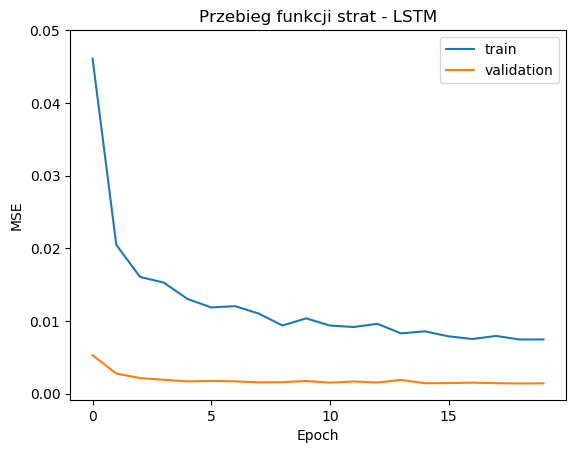

In [145]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Przebieg funkcji strat - LSTM")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.xticks(np.arange(0, N_EPOCH, step=5))
plt.yticks(np.arange(0, history.history["loss"][0] + 0.01, step=0.01))
plt.legend()
plt.show()

In [146]:
predicted_price = model.predict(X_test, verbose=0)

In [147]:
rmse = sqrt(mean_squared_error(y_test, predicted_price))
print("Pierwiastek błędu średniokwadratowego (LSTM): {:.4f}".format(rmse))

Pierwiastek błędu średniokwadratowego (LSTM): 0.0376


In [152]:
score = int(rmse*10000)
model.save(LearningDataPath+"/PredictionModel.h5")
model.save(LearningDataPath+"/LSTM_"+str(n_steps_in)+"_Days_"+str(score)+"rmse.h5")

## 3.2 LSTM - Training

In [ ]:
model = load_model(LearningDataPath+"/LSTM_"+str(n_steps_in)+"_Days_"+str(score)+"rmse.h5")

In [ ]:
train_predicted_price = model.predict(X_train, verbose=0)

In [ ]:
y_scaler = load(open(LearningDataPath+"/y_scaler.pkl", "rb"))
train_predict_index = np.load(LearningDataPath+"/train_predict_index.npy", allow_pickle=True)
rescaled_real_y = y_scaler.inverse_transform(y_train)
rescaled_predicted_y = y_scaler.inverse_transform(train_predicted_price)

In [ ]:
predicted_train_result_LSTM = pd.DataFrame()
for i in range(rescaled_predicted_y.shape[0]):
    y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                             index=train_predict_index[i:i + output_dim])
    predicted_train_result_LSTM = pd.concat([predicted_train_result_LSTM, y_predict], axis=1, sort=False)

In [ ]:
real_train_price = pd.DataFrame()
for i in range(rescaled_real_y.shape[0]):
    y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                           index=train_predict_index[i:i + output_dim])
    real_train_price = pd.concat([real_train_price, y_train], axis=1, sort=False)

In [ ]:
predicted_train_result_LSTM["predicted_mean"] = predicted_train_result_LSTM.mean(axis=1)
real_train_price["real_mean"] = real_train_price.mean(axis=1)

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(real_train_price["real_mean"])
plt.plot(predicted_train_result_LSTM["predicted_mean"], color="r")
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend(("Cena rzeczywista", "Cena przewidywana"), loc="upper left", fontsize=16)
plt.title("Zbiór treningowy - LSTM", fontsize=20)
plt.show()

## 3.3 LSTM - Testing

In [ ]:
model = load_model(LearningDataPath+"/LSTM_"+str(n_steps_in)+"_Days_"+str(score)+"rmse.h5")

In [ ]:
test_predicted_price = model.predict(X_test, verbose=0)

In [ ]:
y_scaler = load(open(LearningDataPath+"/y_scaler.pkl", "rb"))
test_predict_index = np.load(LearningDataPath+"/test_predict_index.npy", allow_pickle=True)
rescaled_real_y = y_scaler.inverse_transform(y_test)
rescaled_predicted_y = y_scaler.inverse_transform(test_predicted_price)

In [ ]:
predicted_test_result_LSMT = pd.DataFrame()
for i in range(rescaled_predicted_y.shape[0]):
    y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                             index=test_predict_index[i:i + output_dim])
    predicted_test_result_LSMT = pd.concat([predicted_test_result_LSMT, y_predict], axis=1, sort=False)

In [ ]:
real_test_price = pd.DataFrame()
for i in range(rescaled_real_y.shape[0]):
    y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                           index=test_predict_index[i:i + output_dim])
    real_test_price = pd.concat([real_test_price, y_train], axis=1, sort=False)

In [ ]:
predicted_test_result_LSMT["predicted_mean"] = predicted_test_result_LSMT.mean(axis=1)
real_test_price["real_mean"] = real_test_price.mean(axis=1)

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(real_test_price["real_mean"])
plt.plot(predicted_test_result_LSMT["predicted_mean"], color="r")
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend(("Cena rzeczywista", "Cena przewidywana"), loc="upper left", fontsize=16)
plt.title("Zbiór testowy - LSTM", fontsize=20)
plt.show()

## 4. GRU & LSTM - Compare

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(real_test_price["real_mean"])
plt.plot(predicted_test_result_GRU["predicted_mean"], color="r")
plt.plot(predicted_test_result_LSMT["predicted_mean"], color="g")
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend(("Cena rzeczywista", "GRU", "LSTM"), loc="upper left", fontsize=16)
plt.title("Porównanie wyników na zbiorze testowym", fontsize=20)
plt.show()